# Convert numpy files to R-readable format

In [204]:
import sys
sys.path.insert(0, '../')

import pandas as pd
from theory import build_S_with_tuples
from load_results import load_results

extension = 'genes_v2.2.0'
mu_method = "variant"

fluxes_mles = load_results('fluxes', 'mles',extension)
fluxes_cis = load_results('fluxes','cis',extension)

selection_mles = load_results('selections', 'mles',extension)
selection_cis = load_results('selections', 'cis',extension)

cesR_mu_dict = load_results('mutations', 'cesR')
variant_mu_dict = load_results('mutations', 'variant')

all_samples = load_results('samples', extension=extension)

In [192]:
mu_df = pd.json_normalize({"cesR":cesR_mu_dict,"variant":variant_mu_dict},sep='|').T.reset_index()
mu_df.columns = ['index','mu']
mu_df[['method','key','gene']] = mu_df['index'].str.split('|', expand=True)
mu_df = mu_df[['method','key','gene','mu']]

mu_df.to_csv('mutation_rates.csv', index=False)

In [193]:
flux_df = pd.json_normalize(fluxes_mles,sep='|').T.reset_index()
flux_df.columns = ['index','flux_mle']

tmp = pd.json_normalize(fluxes_cis,sep='|').T.reset_index()
tmp.columns = ['index','flux_cis']
tmp['flux_ci_low'] = tmp['flux_cis'].apply(lambda x: x[0])
tmp['flux_ci_high'] = tmp['flux_cis'].apply(lambda x: x[1])
# tmp2[['flux_ci_low','flux_ci_high']] = tmp2['flux_cis'].apply(pd.Series)
tmp = tmp.drop('flux_cis',axis=1)

flux_df = pd.merge(flux_df,tmp,on='index')

flux_df[['key','gene_set','mutation']] = flux_df['index'].str.split('|', expand=True)
flux_df = flux_df[['key','gene_set','mutation','flux_mle','flux_ci_low','flux_ci_high']]

flux_df[['first_gene','second_gene','third_gene']] = flux_df['gene_set'].str.strip(',()').str.replace("'","").str.split(', ',expand=True)
flux_df = flux_df.drop('gene_set', axis=1)

flux_df

,key,mutation,flux_mle,flux_ci_low,flux_ci_high,first_gene,second_gene,third_gene
0,pan_data,"((0,), (1,))",5.556099e-01,5.363021e-01,0.575388,TP53,None,None
1,pan_data,"((0,), (1,))",5.230331e-01,5.045681e-01,0.541953,KRAS,None,None
2,pan_data,"((0,), (1,))",1.567351e-01,1.476294e-01,0.166209,EGFR,None,None
3,pan_data,"((0,), (1,))",5.230394e-02,4.725132e-02,0.057705,BRAF,None,None
4,pan_data,"((0,), (1,))",3.447689e-02,3.042403e-02,0.038875,CTNNB1,None,None
...,...,...,...,...,...,...,...,...
15260,nonsmoking_plus,"((0, 1, 0), (1, 1, 0))",1.174089e-29,1.174089e-29,0.241691,CTNNB1,PIK3CA,SMAD4
15261,nonsmoking_plus,"((1, 0, 0), (1, 1, 0))",1.948051e-01,3.194601e-02,0.624389,CTNNB1,PIK3CA,SMAD4
15262,nonsmoking_plus,"((0, 1, 1), (1, 1, 1))",5.949573e-42,5.949573e-42,12.169189,CTNNB1,PIK3CA,SMAD4
15263,nonsmoking_plus,"((1, 0, 1), (1, 1, 1))",7.207799e-42,7.207799e-42,11.765725,CTNNB1,PIK3CA,SMAD4


In [194]:
M1_flux_df = flux_df[flux_df['second_gene'].isnull()]
M1_flux_df = M1_flux_df.drop(['second_gene','third_gene'],axis=1).rename(columns={'first_gene':'gene'})
M1_flux_df = M1_flux_df[['key','gene','flux_mle','flux_ci_low','flux_ci_high']]

M2_flux_df = flux_df[(flux_df['second_gene'].notnull()) & (flux_df['third_gene'].isnull())]
M2_flux_df = M2_flux_df.drop('third_gene',axis=1)
M2_flux_df = M2_flux_df[['key','first_gene','second_gene','mutation','flux_mle','flux_ci_low','flux_ci_high']]

M3_flux_df = flux_df[flux_df['third_gene'].notnull()]
M3_flux_df = M3_flux_df[['key','first_gene','second_gene','third_gene','mutation','flux_mle','flux_ci_low','flux_ci_high']]

M1_flux_df.to_csv('M1_gene_fluxes.csv', index=False)
M2_flux_df.to_csv('M2_gene_fluxes.csv', index=False)
M3_flux_df.to_csv('M3_gene_fluxes.csv', index=False)

In [205]:
gamma_df = pd.json_normalize(selection_mles,sep='|').T.reset_index()
gamma_df.columns = ['index','gamma_mle']

tmp = pd.json_normalize(selection_cis,sep='|').T.reset_index()
tmp.columns = ['index','gamma_cis']
tmp['gamma_ci_low'] = tmp['gamma_cis'].apply(lambda x: x[0])
tmp['gamma_ci_high'] = tmp['gamma_cis'].apply(lambda x: x[1])
tmp = tmp.drop('gamma_cis',axis=1)

gamma_df = pd.merge(gamma_df,tmp,on='index')

gamma_df[['key','gene_set','mutation']] = gamma_df['index'].str.split('|', expand=True)
gamma_df = gamma_df[['key','gene_set','mutation','gamma_mle','gamma_ci_low','gamma_ci_high']]

gamma_df[['first_gene','second_gene','third_gene']] = gamma_df['gene_set'].str.strip(',()').str.replace("'","").str.split(', ',expand=True)
gamma_df = gamma_df.drop('gene_set', axis=1)
gamma_df['method'] = mu_method

gamma_df

,key,mutation,gamma_mle,gamma_ci_low,gamma_ci_high,first_gene,second_gene,third_gene,method
0,pan_data,"((0,), (1,))",7.497217e+05,7.236684e+05,7.764091e+05,TP53,None,None,variant
1,pan_data,"((0,), (1,))",3.897762e+06,3.760157e+06,4.038762e+06,KRAS,None,None,variant
2,pan_data,"((0,), (1,))",2.144670e+05,2.020073e+05,2.274300e+05,EGFR,None,None,variant
3,pan_data,"((0,), (1,))",5.089047e+05,4.597439e+05,5.614518e+05,BRAF,None,None,variant
4,pan_data,"((0,), (1,))",7.299305e+05,6.441251e+05,8.230383e+05,CTNNB1,None,None,variant
...,...,...,...,...,...,...,...,...,...
15260,nonsmoking_plus,"((0, 1, 0), (1, 1, 0))",2.122210e-22,2.122210e-22,4.368653e+06,CTNNB1,PIK3CA,SMAD4,variant
15261,nonsmoking_plus,"((1, 0, 0), (1, 1, 0))",1.469364e+06,2.409604e+05,4.709604e+06,CTNNB1,PIK3CA,SMAD4,variant
15262,nonsmoking_plus,"((0, 1, 1), (1, 1, 1))",1.075408e-34,1.075408e-34,2.199626e+08,CTNNB1,PIK3CA,SMAD4,variant
15263,nonsmoking_plus,"((1, 0, 1), (1, 1, 1))",5.436655e-35,5.436655e-35,8.874580e+07,CTNNB1,PIK3CA,SMAD4,variant


In [206]:
M1_gamma_df = gamma_df[gamma_df['second_gene'].isnull()]
M1_gamma_df = M1_gamma_df.drop(['second_gene','third_gene'],axis=1).rename(columns={'first_gene':'gene'})
M1_gamma_df = M1_gamma_df[['method','key','gene','gamma_mle','gamma_ci_low','gamma_ci_high']]

M2_gamma_df = gamma_df[(gamma_df['second_gene'].notnull()) & (gamma_df['third_gene'].isnull())]
M2_gamma_df = M2_gamma_df.drop('third_gene',axis=1)
M2_gamma_df = M2_gamma_df[['method','key','first_gene','second_gene','mutation','gamma_mle','gamma_ci_low','gamma_ci_high']]

M3_gamma_df = gamma_df[gamma_df['third_gene'].notnull()]
M3_gamma_df = M3_gamma_df[['method','key','first_gene','second_gene','third_gene','mutation','gamma_mle','gamma_ci_low','gamma_ci_high']]

M1_gamma_df.to_csv('M1_gene_gammas.csv', index=False)
M2_gamma_df.to_csv('M2_gene_gammas.csv', index=False)
M3_gamma_df.to_csv('M3_gene_gammas.csv', index=False)

In [197]:
sample_df = pd.json_normalize(all_samples,sep='|').T.reset_index().rename(columns={0:'counts'})
sample_df[['key','gene_set']] = sample_df['index'].str.split('|', expand=True)
sample_df = sample_df.drop('index',axis=1)
sample_df['gene_set'] = sample_df['gene_set'].str.strip(',()')

sample_dict = dict()
for i in range(1,4): 
    sample_dict[i] = sample_df[sample_df['counts'].apply(len)==2**i]
    sample_dict[i][[str(x) for x in build_S_with_tuples(i)]] = sample_dict[i]['counts'].apply(pd.Series)
    
    if i == 1: 
        sample_dict[i]['gene'] = sample_dict[i]['gene_set'].str.replace("'","")
        sample_dict[i] = sample_dict[i][['key','gene'] + [str(x) for x in build_S_with_tuples(i)]]
    elif i == 2: 
        sample_dict[i][['first_gene','second_gene']] = sample_dict[i]['gene_set'].str.replace("'","").str.split(', ',expand=True)
        sample_dict[i] = sample_dict[i][['key','first_gene','second_gene'] + [str(x) for x in build_S_with_tuples(i)]]
    elif i == 3:
        sample_dict[i][['first_gene','second_gene','third_gene']] = sample_dict[i]['gene_set'].str.replace("'","").str.split(', ',expand=True)
        sample_dict[i] = sample_dict[i][['key','first_gene','second_gene','third_gene'] + [str(x) for x in build_S_with_tuples(i)]]

    sample_dict[i].to_csv(f'M{i}_samples_per_combination.csv',index=False)

/var/folders/6c/jgrxdckx13g4fc3tvbx12h040000gp/T/ipykernel_93449/1577326848.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_dict[i][[str(x) for x in build_S_with_tuples(i)]] = sample_dict[i]['counts'].apply(pd.Series)
/var/folders/6c/jgrxdckx13g4fc3tvbx12h040000gp/T/ipykernel_93449/1577326848.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_dict[i][[str(x) for x in build_S_with_tuples(i)]] = sample_dict[i]['counts'].apply(pd.Series)
/var/folders/6c/jgrxdckx13g4fc3tvbx12h040000gp/T/ipyke

Load all genes, M=1 results

In [207]:
import sys
sys.path.insert(0, '../')

import pandas as pd
from theory import build_S_with_tuples
from load_results import load_results

extension = 'genes_v2.2.1'
mu_method == "variant"

fluxes_mles = load_results('fluxes', 'mles',extension)
fluxes_cis = load_results('fluxes','cis',extension)

selection_mles = load_results('selections', 'mles',extension)
selection_cis = load_results('selections', 'cis',extension)

all_samples = load_results('samples', extension=extension)

In [208]:
flux_df = pd.json_normalize(fluxes_mles,sep='|').T.reset_index()
flux_df.columns = ['index','flux_mle']

tmp = pd.json_normalize(fluxes_cis,sep='|').T.reset_index()
tmp.columns = ['index','flux_cis']
tmp['flux_ci_low'] = tmp['flux_cis'].apply(lambda x: x[0])
tmp['flux_ci_high'] = tmp['flux_cis'].apply(lambda x: x[1])
# tmp2[['flux_ci_low','flux_ci_high']] = tmp2['flux_cis'].apply(pd.Series)
tmp = tmp.drop('flux_cis',axis=1)

flux_df = pd.merge(flux_df,tmp,on='index')

flux_df[['key','gene','mutation']] = flux_df['index'].str.split('|', expand=True)
flux_df['gene'] = flux_df['gene'].str.strip(",()'")
flux_df = flux_df[['key','gene','flux_mle','flux_ci_low','flux_ci_high']]


gamma_df = pd.json_normalize(selection_mles,sep='|').T.reset_index()
gamma_df.columns = ['index','gamma_mle']

tmp = pd.json_normalize(selection_cis,sep='|').T.reset_index()
tmp.columns = ['index','gamma_cis']
tmp['gamma_ci_low'] = tmp['gamma_cis'].apply(lambda x: x[0])
tmp['gamma_ci_high'] = tmp['gamma_cis'].apply(lambda x: x[1])
tmp = tmp.drop('gamma_cis',axis=1)

gamma_df = pd.merge(gamma_df,tmp,on='index')

gamma_df[['key','gene','mutation']] = gamma_df['index'].str.split('|', expand=True)
gamma_df['gene'] = gamma_df['gene'].str.strip(",()'")
gamma_df['method'] = mu_method
gamma_df = gamma_df[['method','key','gene','gamma_mle','gamma_ci_low','gamma_ci_high']]

flux_df.to_csv('M1_all_gene_fluxes.csv', index=False)
gamma_df.to_csv('M1_all_gene_gammas.csv', index=False)

In [200]:
sample_df = pd.json_normalize(all_samples,sep='|').T.reset_index().rename(columns={0:'counts'})
sample_df[['key','gene_set']] = sample_df['index'].str.split('|', expand=True)
sample_df = sample_df.drop('index',axis=1)
sample_df['gene_set'] = sample_df['gene_set'].str.strip(",()'")

sample_df[[str(x) for x in build_S_with_tuples(1)]] = sample_df['counts'].apply(pd.Series)
sample_df['gene'] = sample_df['gene_set'].str.replace("'","")
sample_df = sample_df[['key','gene'] + [str(x) for x in build_S_with_tuples(1)]]

sample_df.to_csv(f'M1_all_samples_per_combination.csv',index=False)

# Plotting trajectories

In [1]:
import pandas as pd
import numpy as np

import sys
sys.path.insert(0, '../')

#from cancer_epistasis import convert_samples_to_dict
def convert_samples_to_dict(samples):
    M = int(np.log2(len(samples)))
    S = build_S_as_array(M)
    results_as_dict = {tuple(x):value
                       for x, value in zip(S, samples)}

    return results_as_dict

# from locations import location_output

# from landscape_plotting import plot_landscape
# from landscape_plotting import positions_landscape

def order_pos_lambdas(S):
    pos_lambdas_indices = obtain_pos_lambdas_indices(S)
    pos_lambdas_ordered = [(tuple(S[j]), tuple(S[i]))
                           for i in range(len(S))
                           for j in range(len(S))
                           if pos_lambdas_indices[i, j]]
    return pos_lambdas_ordered

def build_S_as_array(M):
    return np.array(build_S_with_tuples(M))

from load_results import load_results

fluxes_mles = load_results('fluxes', 'mles','genes_v2.0')
fluxes_cis = load_results('fluxes','cis','genes_v2.0')

selection_mles = load_results('selections', 'mles','genes_v2.0')
selection_cis = load_results('selections', 'cis','genes_v2.0')

cesR_mu_dict = load_results('mutations', 'cesR','genes_v2.0')
variant_mu_dict = load_results('mutations', 'variant','genes_v2.0')

all_samples = load_results('samples', extension='genes_v2.0')

/var/folders/6c/jgrxdckx13g4fc3tvbx12h040000gp/T/ipykernel_78598/1404017455.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [23]:
def plot_trajectory(gene_list, dataset_key, param="selection", scale_circle_areas=0.01,multiplier_font_size=1.5,scale_arrows=None):
    if not isinstance(gene_list,list):
        raise TypeError("`gene_list` must be a list of genes")
    if param not in ["fixation","mutation","selection"]: 
        raise ValueError("`param` must be one of 'fixation','mutation','selection'")
    if scale_arrows is None:
        if param == "fixation": scale_arrows = 1
        elif param == "mutation": scale_arrows = 1*10**5
        elif param == "selection": scale_arrows = 0.5*10**(-6)
    
    gene_tuple = tuple(gene_list)

    if param == "fixation": values = fluxes_mles[dataset_key][gene_tuple]
    elif param == "mutation": 
        T = order_pos_lambdas(build_S_as_array(len(gene_list))) # list of transitions
        T_ = np.array(T)
        mutated_indices = np.where(T_[:,1] - T_[:,0])[1] # mutated gene for each transition
        values = {T[i]: cesR_mu_dict[dataset_key][gene_tuple[mutated_indices[i]]] for i in range(len(T))} # create dictionary with mutation rates
    elif param == "selection": values = selection_mles[dataset_key][gene_tuple]

    p = plot_landscape(
        arrows = values,
        circle_areas = convert_samples_to_dict(all_samples[dataset_key][gene_tuple]),
        mutation_names = gene_tuple,
        scale_arrows=scale_arrows,
        positions="left_to_right",
        include_n_circles=True,
        scale_circle_areas=scale_circle_areas,
        multiplier_font_size=multiplier_font_size,
        plot_name='trajectory' + dataset_key + '_'.join(gene_tuple) + param
    )
    return p

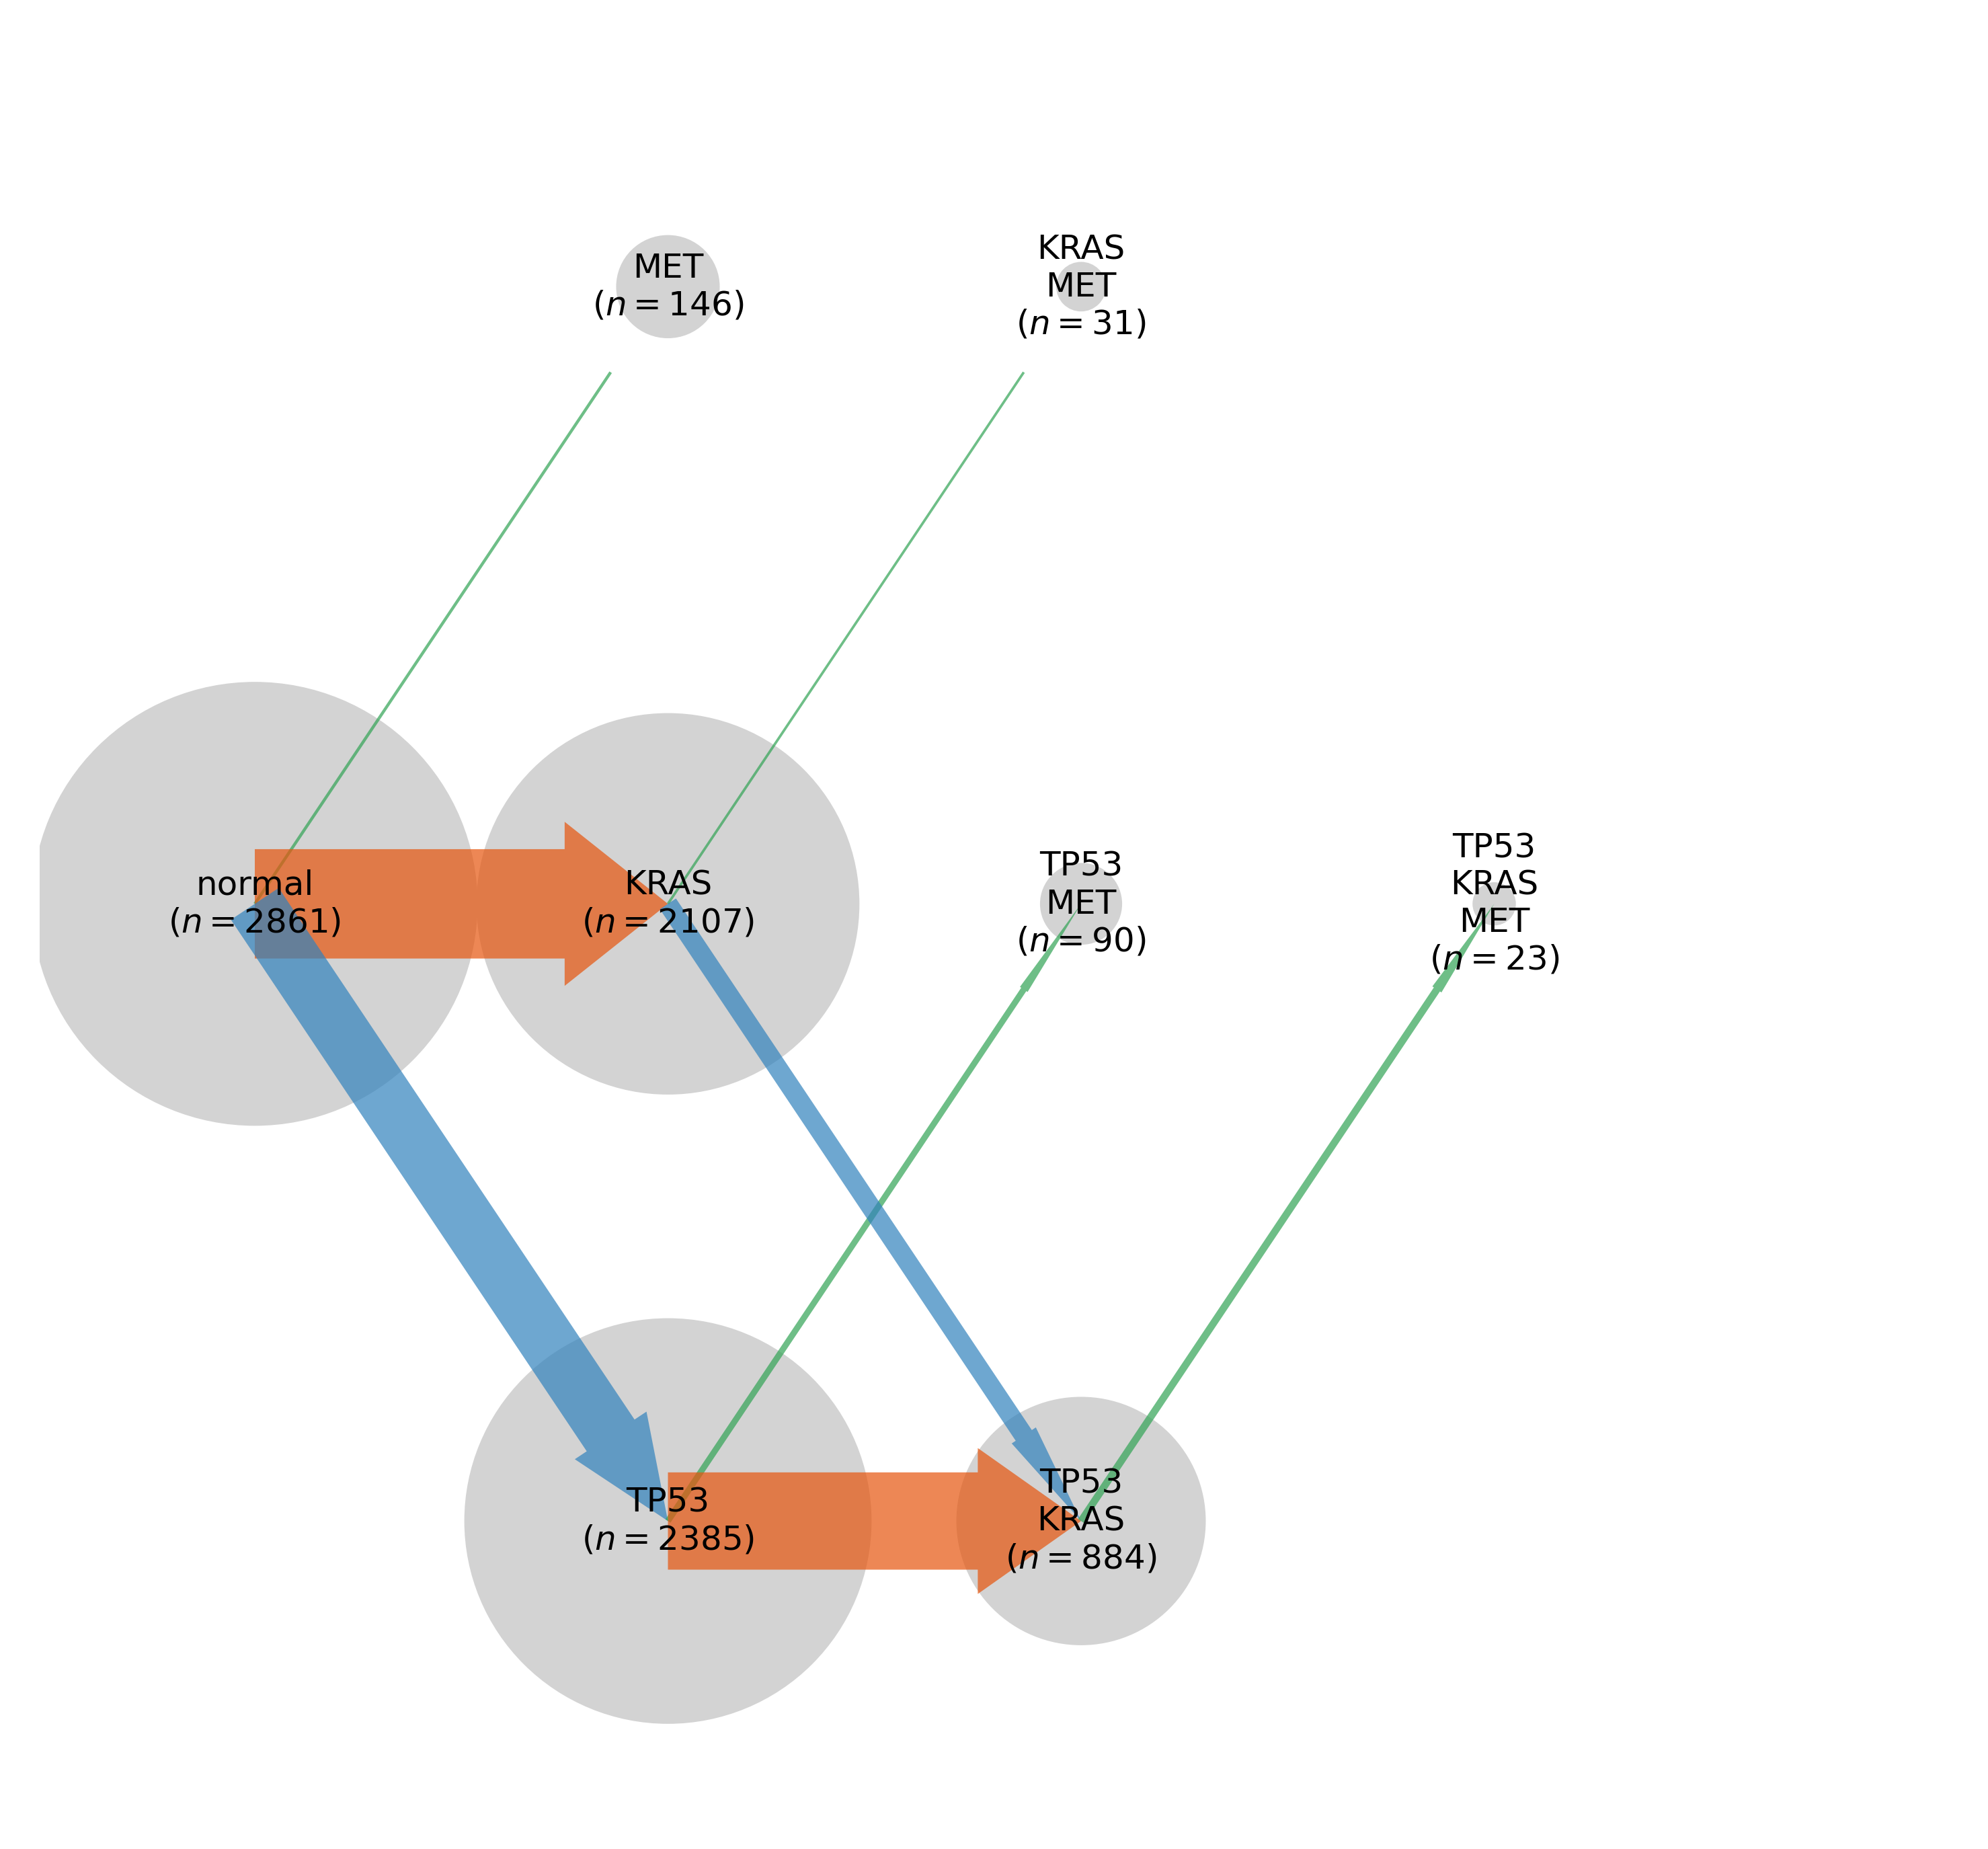

In [26]:
plot_trajectory(['TP53', 'KRAS', 'MET'],'pan_data','selection')

## For higher order interaction plot

### Fitness Rescue
#### CTNNB1 ['BRAF', 'CTNNB1', 'KEAP1']

### Super-synergism

#### RB1 ['TP53', 'PIK3CA', 'RB1']

#### APC ['TP53', 'ATM', 'APC']

### Less benefit than expected

#### CTNNB1 ['TP53', 'EGFR', 'CTNNB1']

#### KEAP1 ['KRAS', 'CTNNB1', 'KEAP1']

# Pathways

In [21]:
hm_df = pd.read_csv("../../data/gene_sets/hallmark_pathway_df.csv")

#HALLMARK_TNFA_SIGNALING_VIA_NFKB = list(hm_df[hm_df["pathway"]=="HALLMARK_TNFA_SIGNALING_VIA_NFKB"]["genes"])[0].split("|")
HALLMARK_HYPOXIA = list(hm_df[hm_df["pathway"]=="HALLMARK_HYPOXIA"]["genes"])[0].split("|")
HALLMARK_WNT_BETA_CATENIN_SIGNALING = list(hm_df[hm_df["pathway"]=="HALLMARK_WNT_BETA_CATENIN_SIGNALING"]["genes"])[0].split("|")
HALLMARK_DNA_REPAIR = list(hm_df[hm_df["pathway"]=="HALLMARK_DNA_REPAIR"]["genes"])[0].split("|")
HALLMARK_G2M_CHECKPOINT = list(hm_df[hm_df["pathway"]=="HALLMARK_G2M_CHECKPOINT"]["genes"])[0].split("|")

HALLMARK_PI3K_AKT_MTOR_SIGNALING = list(hm_df[hm_df["pathway"]=="HALLMARK_PI3K_AKT_MTOR_SIGNALING"]["genes"])[0].split("|")
HALLMARK_MYC_TARGETS_V2 = list(hm_df[hm_df["pathway"]=="HALLMARK_MYC_TARGETS_V2"]["genes"])[0].split("|")
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION = list(hm_df[hm_df["pathway"]=="HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION"]["genes"])[0].split("|")
HALLMARK_INFLAMMATORY_RESPONSE = list(hm_df[hm_df["pathway"]=="HALLMARK_INFLAMMATORY_RESPONSE"]["genes"])[0].split("|")
HALLMARK_METABOLISM = list(hm_df[hm_df["pathway"]=="HALLMARK_OXIDATIVE_PHOSPHORYLATION"]["genes"])[0].split("|") + list(hm_df[hm_df["pathway"]=="HALLMARK_GLYCOLYSIS"]["genes"])[0].split("|")

HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY = list(hm_df[hm_df["pathway"]=="HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY"]["genes"])[0].split("|")
HALLMARK_P53_PATHWAY = list(hm_df[hm_df["pathway"]=="HALLMARK_P53_PATHWAY"]["genes"])[0].split("|")
HALLMARK_ANGIOGENESIS = list(hm_df[hm_df["pathway"]=="HALLMARK_ANGIOGENESIS"]["genes"])[0].split("|")
HALLMARK_KRAS = list(hm_df[hm_df["pathway"]=="HALLMARK_KRAS_SIGNALING_UP"]["genes"])[0].split("|") + list(hm_df[hm_df["pathway"]=="HALLMARK_KRAS_SIGNALING_DN"]["genes"])[0].split("|")